In [1]:
import numpy as np
from scipy.linalg import expm
from random import sample, shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Gamma_to_sink=5.
nsig = 5

#System evolution
def evolve(r0, H, t):
    N_in=H.shape[0]
    
    I=np.eye(N_in, dtype="complex64")
    sm=np.zeros([N_in,N_in], dtype="complex64")
    sm[0,2]=1
    sp=np.zeros([N_in,N_in], dtype="complex64")
    sp[2, 0]=1
    
    L_uni=np.kron(I, H)-np.kron(H.transpose().conjugate(), I)
    L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
    return (expm((1j*L_uni+L_sink)*t)@r0).real[0]


#Chain class
class QNetwork:
    def __init__(self, J0=1., T=1., N_max=11): 
        self.J=J0
        self.T=T
        self.DE=1.
        self.N_max=N_max
        self.sigma = 0.5/(nsig*(N_max-1))
        self.limit_disorder = 0.5/(N_max-1) - 1e-8
        
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
    
    #Interactions
    def H_ij(self, x_i, x_j):
        return self.J/((np.linalg.norm(x_j-x_i))**3)
    
    #Add new node to the chain and update Hamiltonian and state
    def add_node(self, nx):
        self.nodes_coordinates[nx]=1.
        x=float(nx)/(self.N_max-1) + max(-self.limit_disorder, min(np.random.normal(scale=self.sigma), self.limit_disorder))  #qui puoi aggiungere disordine
        
        id_last=self.H.shape[0]
        H_new = self.H.copy()
        H_new=np.vstack((np.hstack((H_new, np.zeros([id_last,1], complex))), np.zeros([1,id_last+1], complex)))
        for i in range(1, id_last):
            H_new[id_last,i]=self.H_ij(x, self.nodes_positions[i])
            H_new[i, id_last]=H_new[id_last,i]
        H_new[id_last, id_last]=self.DE
        
        rho0=np.zeros([id_last+1, id_last+1])
        rho0[1,1]=1
        rho0=rho0.reshape((id_last+1)**2)
        
        self.rho0=rho0
        self.nodes_positions+=[np.array(x)]
        self.H=H_new
       
    
    #FOR REINFORCEMENT LEARNING
    #Reset chain to the original configuration
    def reset(self):
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
        return self.nodes_coordinates
    
    #MDP step
    def step(self, action):
        terminated=False
        if self.nodes_coordinates[action]<1:
            r0 = evolve(self.rho0, self.H, self.T)
            self.add_node(action)
            r1 = evolve(self.rho0, self.H, self.T)
            reward = r1 - r0
            if r1>0.99: terminated = True
        else:
            reward = 0.
            #terminated = True
        
        return self.nodes_coordinates, reward, terminated

In [3]:
eps=1e-10

#Physical parameters
N=21
J0=0.05
T=5.

#environment
num_obs = N
num_acts = N
max_steps_per_episode=11

#learning
gamma=0.99
lmbda = 0.95
num_agents = 100
num_epochs = 4
batchsize = 128
#cS = 0.001

clip_ratio = 0.2
kinit = tf.keras.initializers.HeUniform()
loss_function = keras.losses.Huber() #MeanSquaredError() #

lr_actor = 8e-5
optimizer_actor = keras.optimizers.Adam(learning_rate=lr_actor)

lr_critic= 1e-4
optimizer_critic = keras.optimizers.Adam(learning_rate=lr_critic)


#Actor
inputs_act = layers.Input(shape=(num_obs,))
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
output_act = layers.Dense(num_acts, activation="softmax")(hid_act)
actor = keras.Model(inputs=inputs_act, outputs=output_act)

#Critic
inputs_crit = layers.Input(shape=(num_obs,))
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
hid_crit = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_crit)
output_crit = layers.Dense(1, activation="linear")(hid_crit)
critic = keras.Model(inputs=inputs_crit, outputs=output_crit)

#Initialize
opt=[]
current_max=-100

env = QNetwork(J0, T, N)

In [4]:
def preprocess(states, actions, rewards, done, values): 
    g = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * done[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    return returns, adv.tolist()

def learn_epoch(states, actions, advs, old_probs, returns):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            probs = actor(states)
            values = critic(states)
            L_clip = -sum([min(advs[batch]*probs[batch][actions[batch]]/old_probs[batch][actions[batch]], tf.clip_by_value(probs[batch][actions[batch]]/old_probs[batch][actions[batch]], 1.-clip_ratio, 1.+clip_ratio)*advs[batch]) for batch in range(batchsize)])/batchsize
            L_crit = loss_function(values, returns.astype("float32"))
            #L_entropy = -sum([-tf.tensordot(probs[batch], tf.math.log(probs[batch]+eps), axes=1) for batch in range(batchsize)])/batchsize
         
                
            grads1 = tape1.gradient(L_clip, actor.trainable_variables) #+cS*L_entropy
            grads2 = tape2.gradient(L_crit, critic.trainable_variables)
        
            optimizer_actor.apply_gradients(zip(grads1, actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(grads2, critic.trainable_variables))
    
    return L_clip.numpy(), L_crit.numpy(), 0#cS*L_entropy.numpy()

In [27]:
actions_history = []
states_history = []
advs_history = []
returns_history = []
probs_history = []

test_performance = []

num_episodes = 3000
episode_count = 0

while True:
    opt_rew=-100
    performance_episode = 0
    for agent in range(num_agents):
        actions_agent = []
        states_agent = []
        values_agent = []
        done_agent = []
        rewards_agent = []
        probs_agent = []
        
        state=env.reset()
        for timestep in range(1, max_steps_per_episode):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = actor(state_tensor, training=False)
            critic_values = critic(state_tensor, training=False)
            action = np.random.choice(num_acts, p=np.squeeze(action_probs))
            
            state_next, reward, done = env.step(action)
            state_next = np.array(state_next, dtype=np.float32)
            
            probs_agent.append(np.squeeze(action_probs))
            actions_agent.append(action)
            states_agent.append(state)
            values_agent.append(critic_values.numpy()[0][0])
            done_agent.append(1-done)
            rewards_agent.append(reward)
            state = state_next
            
            performance_episode+=reward
            if reward>opt_rew: opt_rew=reward
            
            if done:
                break
                
        final_pops = evolve(env.rho0, env.H, env.T)
        if final_pops > current_max:
            current_max = final_pops
            opt = env.nodes_coordinates
                
        values_agent.append(0.)
            
        returns_agent, advs_agent = preprocess(states_agent, actions_agent, rewards_agent, done_agent, values_agent)
        
        actions_history += actions_agent
        states_history += states_agent
        returns_history += returns_agent
        advs_history += advs_agent
        probs_history += probs_agent
        
    #advs_history = ((np.array(advs_history) - np.array(advs_history).mean())/np.array(advs_history).std()).tolist()
    test_performance += [performance_episode/(num_agents)]
    
    lossA = 0
    lossC = 0
    lossS = 0
    for epoch in range(num_epochs):
        indices = np.random.choice(range(len(returns_history)), size=batchsize)
        states_sample = np.array([states_history[i] for i in indices])
        actions_sample = np.array([actions_history[i] for i in indices])
        probs_sample = np.array([probs_history[i] for i in indices])
        returns_sample = np.array([returns_history[i] for i in indices])
        advs_sample = np.array([advs_history[i] for i in indices])
        lossA_epoch, lossC_epoch, lossS_epoch = learn_epoch(states_sample, actions_sample, advs_sample, probs_sample, returns_sample)
        lossA += lossA_epoch/num_epochs
        lossC += lossC_epoch/num_epochs
        lossS += lossS_epoch/num_epochs
    
    max_prob = probs_history[0].max()
    
    actions_history.clear()
    states_history.clear()
    returns_history.clear()
    advs_history.clear()
    probs_history.clear()
    
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops = evolve(env.rho0, env.H, env.T)
    
    print(episode_count, current_max, final_pops, opt_rew, max_prob, lossC, test_performance[-1])
    
    episode_count+= 1   
    if episode_count>num_episodes:
        break

0 0.06197500554679589 0.04532757295192839 0.9379149398779963 0.1124355 0.2817121706902981 -0.0029924814701926517
1 0.0821079197063281 0.04562688584931802 0.7902181754016111 0.11278968 0.24583562463521957 -0.002899376628775141
2 0.17651306368940767 0.05056930016136055 0.9399697969248813 0.11249356 0.18867860361933708 -0.0022001374918627693
3 0.6885316338259825 0.0441309364647036 0.9062586060012495 0.112634495 0.14515037089586258 0.0059313324455711166
4 0.6885316338259825 0.04488845114094554 0.846608682579113 0.11306989 0.1494692675769329 0.001705006456251338
5 0.6885316338259825 0.045602453407994126 0.8929482130078438 0.11315203 0.12583099119365215 0.0016392652533012955
6 0.9984258746792154 0.045726940017757935 0.804066007638038 0.11305497 0.11522954516112804 0.01072524648130996
7 0.9984258746792154 0.046250805012468164 0.7748870586024926 0.11269224 0.10924079269170761 0.008790008295702988
8 0.9999180201595057 0.04235609267824626 0.9010110931637739 0.11217518 0.08744160644710064 0.01844

72 0.9999180201595057 0.04749942551363175 0.9210216815543465 0.12037547 0.024658906273543835 0.027607564000779364
73 0.9999180201595057 0.04090104647361207 0.8773063986043879 0.12053823 0.019978416617959738 0.031077278850565188
74 0.9999180201595057 0.04326118582172102 0.8775844287136082 0.12026743 0.016872128937393427 -0.0021684970688805867
75 0.9999180201595057 0.04507816593343728 0.7311267212932524 0.11958277 0.012460853205993772 -0.0007695997961553075
76 0.9999180201595057 0.04270681497953333 0.8795953672922046 0.119025856 0.0203864392824471 0.014571130164476863
77 0.9999180201595057 0.04699809477687441 0.9203847296871185 0.11806747 0.016765707172453403 0.019759983333094134
78 0.9999180201595057 0.04874894103926198 0.903240392822027 0.11745882 0.014550343388691545 0.006948220792693277
79 0.9999180201595057 0.043392442526562686 0.9483498399718788 0.11742208 0.015738470479846 0.016976301776318935
80 0.9999180201595057 0.04407688087995191 0.8228542681252717 0.11752903 0.01079329685308

144 0.9999180201595057 0.04448964670203184 0.9469057285079531 0.12543362 0.018059181980788708 0.034517103528822216
145 0.9999180201595057 0.05296373138315903 0.9457625393867649 0.12412567 0.018017403781414032 0.035918013530142893
146 0.9999180201595057 0.042453841621219866 0.7524995181886672 0.12274171 0.009223558008670807 0.0015956769758346098
147 0.9999180201595057 0.04345821262464395 0.9287949856652727 0.12165263 0.015603703679516912 0.022280184302767635
148 0.9999180201595057 0.04249939882376156 0.935573624798494 0.12093975 0.012142435065470636 0.0189455713369603
149 0.9999180201595057 0.0472267547588828 0.9260808342253082 0.12048036 0.013584149535745382 0.032702611059283536
150 0.9999180201595057 0.0436887194795601 0.9446503679773584 0.12000849 0.011531026102602482 0.01774072300149402
151 0.9999180201595057 0.04466221076520122 0.9197701844565387 0.11971498 0.00993536994792521 0.013108607787823672
152 0.9999180201595057 0.04339343009119661 0.7623038313942878 0.11928758 0.0117555242

216 0.9999180201595057 0.045099670909312356 0.9628450021040276 0.12668248 0.012445254484191537 0.02927722774493692
217 0.9999180201595057 0.04420043387492009 0.9294898619382963 0.12770814 0.016203642822802067 0.05283217384745629
218 0.9999180201595057 0.04515101183446232 0.9344404455037444 0.12884863 0.018695705104619265 0.0482873134870591
219 0.9999180201595057 0.04072144173556778 0.9908701894325471 0.1296249 0.021591999102383852 0.05113756407979946
220 0.9999180201595057 0.043875299639779916 0.8219317147694817 0.13050212 0.012954794568940997 0.026711187625014222
221 0.9999180201595057 0.040311281960956964 0.9660577141856288 0.13082495 0.012424467597156763 0.03209459095228164
222 0.9999180201595057 0.043994142870398656 0.926524021354315 0.13137886 0.013897743076086044 0.014082625090411456
223 0.9999180201595057 0.043854483153344066 0.9115689411354442 0.1317843 0.020007231272757053 0.0328419097778666
224 0.9999180201595057 0.04860616674072368 0.9423446305188952 0.13224408 0.01781071163

288 0.9999180201595057 0.0499755954651022 0.9755340204464427 0.14449173 0.024147829972207546 0.08310648742569801
289 0.9999180201595057 0.04366407909081067 0.955741655569214 0.14611025 0.03073345171287656 0.0910107930273242
290 0.9999180201595057 0.045819427406668195 0.9322066827524798 0.14737037 0.02649450721219182 0.08222308446625061
291 0.9999180201595057 0.0435774330095544 0.9506435451838011 0.14858091 0.016903073992580175 0.07212479416078756
292 0.9999180201595057 0.04455393509909091 0.9491332363662612 0.14928576 0.026724372524768114 0.0991841628125577
293 0.9999180201595057 0.045668165863107485 0.9503852376421706 0.15036127 0.01821724371984601 0.07253330068523951
294 0.9999180201595057 0.0464448103858938 0.9717448631964097 0.14944622 0.027912213001400232 0.10443090428540178
295 0.9999180201595057 0.04318143257777028 0.9767680317187479 0.1482088 0.022928617894649506 0.06674898654416354
296 0.9999180201595057 0.04998608310585344 0.915025757279045 0.14773344 0.02260234160348773 0.05

361 0.9999180201595057 0.04340278217811594 0.9571921393491624 0.16290385 0.02684684982523322 0.09607473776686602
362 0.9999180201595057 0.046078898610747654 0.985204598674478 0.16566306 0.03243522439152002 0.16492135242068837
363 0.9999180201595057 0.04659265686923954 0.9622577092481539 0.16705145 0.024788349401205778 0.1148803736794383
364 0.9999180201595057 0.0459765156714219 0.9825670471956717 0.16831444 0.041996682062745094 0.18535162395213597
365 0.9999180201595057 0.046892265610985716 0.947278566686913 0.16993064 0.03590072179213166 0.16807557336522777
366 0.9999180201595057 0.04153858137681223 0.989217964108355 0.17025802 0.03271256573498249 0.13176972620554042
367 0.9999180201595057 0.04555250813905912 0.9507931922776882 0.16998701 0.025462978053838015 0.09910074915903286
368 0.9999180201595057 0.050871268508337716 0.9742342523094414 0.17033987 0.02869166899472475 0.11206118976615119
369 0.9999180201595057 0.048281430563897616 0.9383503574316112 0.17159976 0.03412197111174464 0

434 0.9999180201595057 0.1631470935476924 0.975266220079261 0.23708318 0.08461600355803967 0.5317144752270838
435 0.9999180201595057 0.18986382680353148 0.9840747249638447 0.23550788 0.07324334047734737 0.5651699542614178
436 0.9999180201595057 0.211466733733977 0.973907985897421 0.2330454 0.07506282813847065 0.559565459388885
437 0.9999180201595057 0.13918262360690548 0.9683484486164025 0.23088104 0.07666630297899246 0.6393147250674807
438 0.9999180201595057 0.16164647984194258 0.9870710254430322 0.23113099 0.06980411894619465 0.5686095249708337
439 0.9999180201595057 0.9764193886641953 0.9721077324124364 0.23186952 0.08194472827017307 0.6162908562903755
440 0.9999180201595057 0.9666057138522621 0.9814086042485861 0.2336051 0.07368266396224499 0.704214527842732
441 0.9999180201595057 0.9805926212650911 0.9761808378567134 0.23610955 0.07399771362543106 0.6191705797608208
442 0.9999180201595057 0.9893217161877871 0.9835370886970504 0.24238375 0.07226803340017796 0.6472744333142957
443 0

509 0.9999180201595057 0.9718104025297186 0.9757445231084628 0.2904845 0.08719257079064846 0.9084695538422516
510 0.9999180201595057 0.9908059567809976 0.9400998582386811 0.28807288 0.08907243609428406 0.9300056665660708
511 0.9999180201595057 0.9760567666278356 0.910776932943544 0.28297344 0.08894681371748447 0.8785873190105469
512 0.9999180201595057 0.9824355843825684 0.9599310836703366 0.2794078 0.08594022318720818 0.9119526759491663
513 0.9999180201595057 0.9884385140235868 0.9714104419769645 0.2770193 0.09485639818012714 0.9099833756181768
514 0.9999180201595057 0.9861379783673957 0.953430936143444 0.27400285 0.09377563372254372 0.9348269166376307
515 0.9999180201595057 0.9161997296614881 0.9887222727824401 0.27191913 0.08647264912724495 0.9228019400994941
516 0.9999180201595057 0.9600119580548095 0.9549876677846056 0.26879895 0.09348340332508087 0.9144564040264561
517 0.9999180201595057 0.9658104811099144 0.9740493948810376 0.2669859 0.09665938466787338 0.8783018098813485
518 0.9

584 0.9999180201595057 0.9470359188361692 0.9701257989793318 0.28421623 0.08625591732561588 0.921067575454107
585 0.9999180201595057 0.9884842070601508 0.9533424989492436 0.28513223 0.08931679464876652 0.94573284165674
586 0.9999180201595057 0.9914491289122421 0.9791962304950018 0.28262088 0.09061124175786972 0.9377232354701123
587 0.9999180201595057 0.9933259733364221 0.9553833661522639 0.2799183 0.08993986435234547 0.9488141364769102
588 0.9999180201595057 0.9863499463866414 0.9714824270195676 0.2766938 0.08910935930907726 0.9454971201508116
589 0.9999180201595057 0.9587884846848893 0.9157921576761479 0.27758303 0.09053976275026798 0.9280791637340029
590 0.9999180201595057 0.9802307950645783 0.9113981337241777 0.2749742 0.09056261368095875 0.9528011695818053
591 0.9999180201595057 0.972255711222558 0.9366720098227064 0.27160266 0.09575742110610008 0.9566789706429166
592 0.9999180201595057 0.9738514952876688 0.989445340009583 0.26692915 0.09278732165694237 0.9174052669003012
593 0.999

659 0.9999180201595057 0.9771886257213995 0.9373195146820166 0.2851595 0.09094874560832977 0.9665405119843682
660 0.9999180201595057 0.9798157434491178 0.9389686790914678 0.287708 0.08942074701189995 0.9571016137494951
661 0.9999180201595057 0.9718783031525554 0.9155658918074511 0.28921437 0.09331376478075981 0.9382372000465711
662 0.9999180201595057 0.9738296105559408 0.875871740775341 0.29287437 0.09239261411130428 0.9517136163396388
663 0.9999180201595057 0.960447199642435 0.9857426946687294 0.2951941 0.09023627638816833 0.9551134757108268
664 0.9999180201595057 0.9876824750548688 0.9212139256900698 0.2957077 0.08871396072208881 0.9469158736011751


KeyboardInterrupt: 

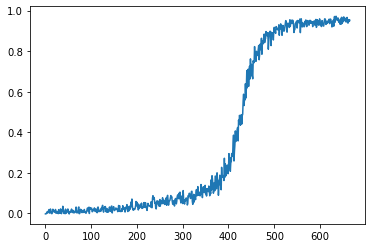

In [28]:
plt.plot(test_performance)

In [35]:
Ntests = 5000
final_pops = 0.
for n in range(Ntests):
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops += evolve(env.rho0, env.H, env.T)
print(final_pops/float(Ntests))

0.9790507044815103


In [30]:
print(state)

[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]


In [32]:
np.savetxt("PPOchain_grid21_disordered5sigma_J_0_05_learning.csv", np.array(test_performance), delimiter=",")

In [33]:
actor.save("PPOchain_grid21_disordered5sigma_J_0_05_actor")
critic.save("PPOchain_grid21_disordered5sigma_J_0_05_critic")

INFO:tensorflow:Assets written to: PPOchain_grid21_disordered5sigma_J_0_05_actor\assets
INFO:tensorflow:Assets written to: PPOchain_grid21_disordered5sigma_J_0_05_critic\assets
